In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from plotnine import *

from py_helper_functions import *

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment1/morg-2014-emp.csv')
df.head()

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent
2,6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,...,2,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work
3,10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,...,2,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work
4,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,...,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work


In [3]:
# Filter the data for occ2012 between 7700 and 8965, work week > 0, work minimum 20hrs per week and hourly wage >= 1
comp_sample = df[(df['occ2012'] >= 7700)
                & (df['occ2012'] <= 8965)
                & (df['uhours'] >= 20) 
                & (df['earnwke'] > 0)
                & (df['earnwke']/df['uhours'] >= 1)].iloc[:, 1:]

#drop the raw df
del df

In [4]:
# Add a column 'hourly_wage' to the DataFrame
comp_sample['hourly_wage'] = comp_sample['earnwke'] / comp_sample['uhours']
# Add the natural log of wage (ln_wage) column
comp_sample['ln_wage'] = np.log(comp_sample['hourly_wage'])
# add column female to have boolean for male or female
comp_sample['female'] = comp_sample['sex'].apply(lambda x: 1 if x == 2 else 0)
# create dummy variables for Bachelor degree holders and Post Graduate degree holders
comp_sample['ed_BA'] = (comp_sample["grade92"] == 43).astype(int)
comp_sample['ed_PostGrad'] = (comp_sample["grade92"] >= 44).astype(int)

In [5]:
# check the comp_sample data
comp_sample.head()

,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,age,...,occ2012,class,unionmme,unioncov,lfsr94,hourly_wage,ln_wage,female,ed_BA,ed_PostGrad
2,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,30,...,8140,"Private, For Profit",No,No,Employed-At Work,18.166667,2.899588,0,0,0
3,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,48,...,8255,"Private, For Profit",Yes,NaN,Employed-At Work,19.230750,2.956511,0,0,0
59,911119970316009,January,AL,5243.6118,346.15,40,40,3,NaN,47,...,8800,"Private, For Profit",No,No,Employed-At Work,8.653750,2.157993,0,0,0
75,199840552350630,January,AL,3354.4158,1265.00,55,39,2,NaN,40,...,8740,"Private, For Profit",Yes,NaN,Employed-At Work,23.000000,3.135494,0,0,0
81,431090259100833,January,AL,3394.3625,1000.00,40,39,1,NaN,46,...,8140,"Private, For Profit",No,No,Employed-At Work,25.000000,3.218876,0,0,0


In [6]:
# get the comp_sample summary statistics
comp_stats = comp_sample[['earnwke', 'uhours', 'hourly_wage', 'ln_wage']].describe().T
comp_stats['mode'] = comp_sample[['earnwke', 'uhours', 'hourly_wage', 'ln_wage']].mode().squeeze()
comp_stats.T

,earnwke,uhours,hourly_wage,ln_wage
count,9066.000000,9066.000000,9066.000000,9066.000000
mean,749.810965,41.139201,17.947816,2.773881
std,434.509624,6.698505,9.411425,0.471172
min,27.000000,20.000000,1.000000,0.000000
25%,460.000000,40.000000,11.500000,2.442347
50%,640.000000,40.000000,15.500000,2.740840
75%,920.000000,40.000000,21.634500,3.074289
max,2884.610000,99.000000,72.115250,4.278266
mode,400.000000,40.000000,10.000000,2.302585


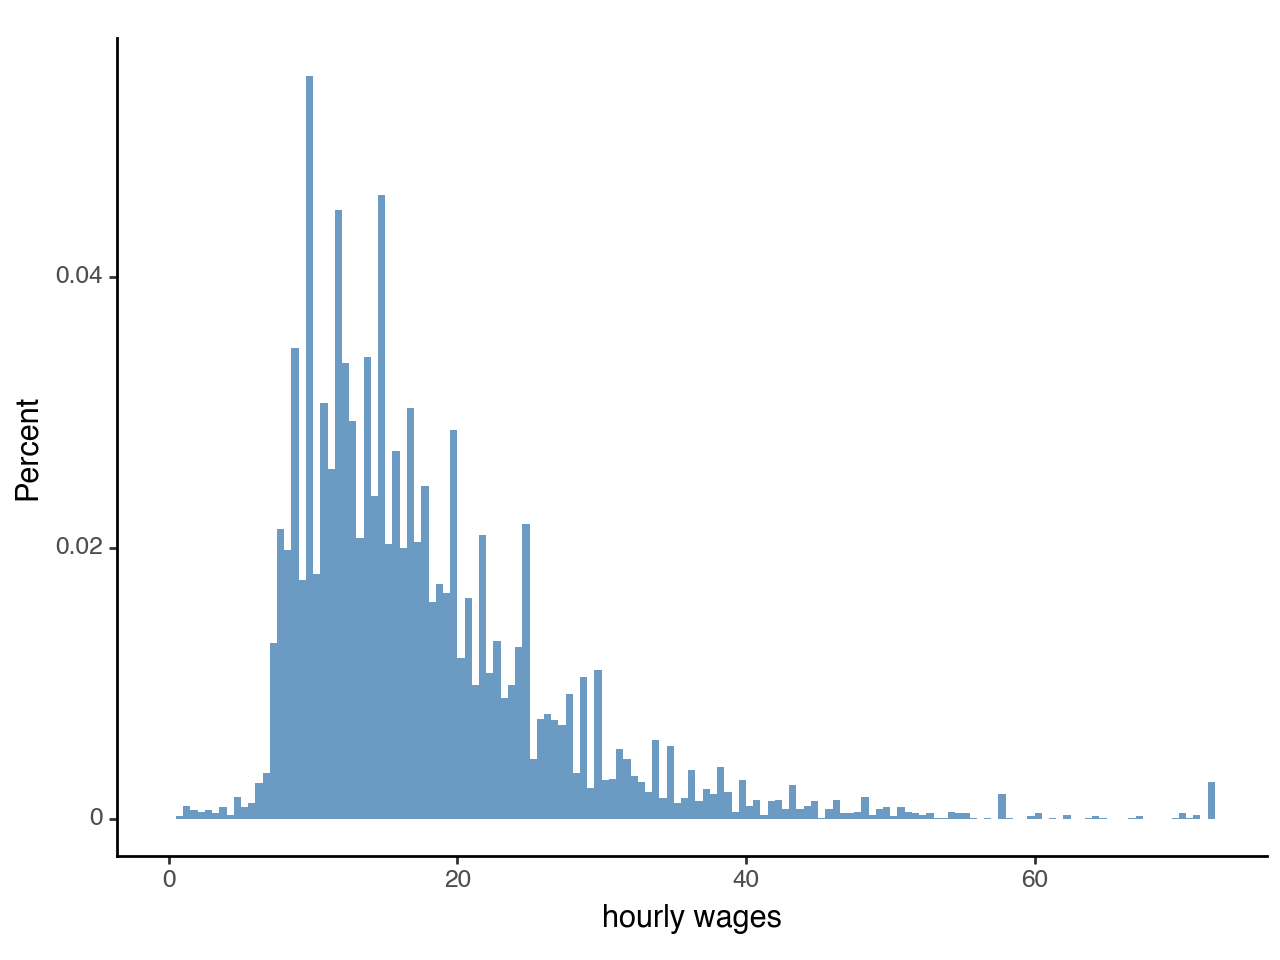

<Figure Size: (640 x 480)>

In [7]:
# hourly_wage distribution
(
    ggplot(comp_sample, aes(x="hourly_wage", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=0.5,
        boundary=0,
        size=0.25,
        alpha=0.8,
        show_legend=True,
        na_rm=True,
        fill='steelblue'
    )
    + labs(x="hourly wages", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + theme_classic()
)

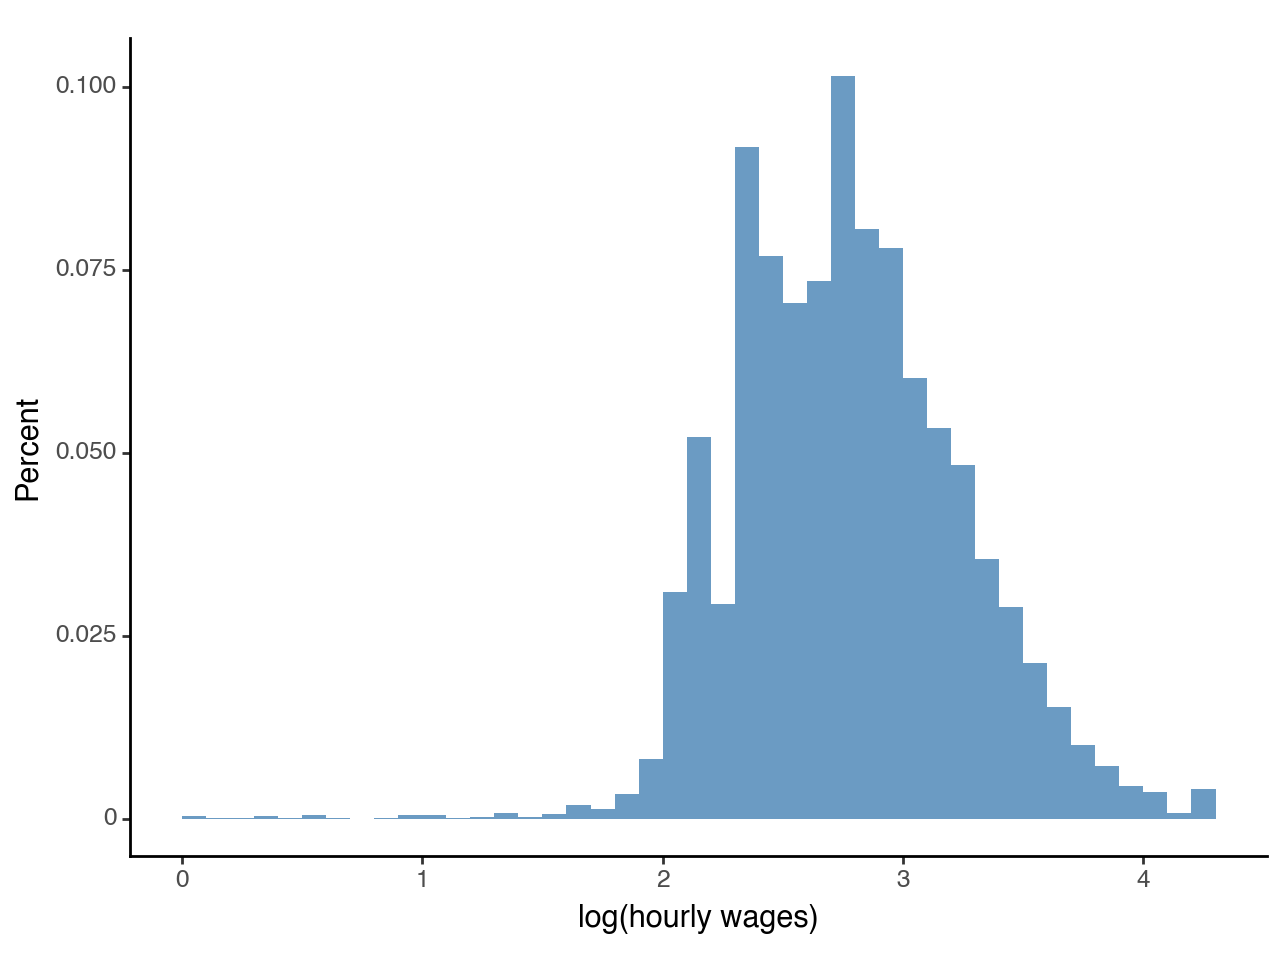

<Figure Size: (640 x 480)>

In [8]:
# ln(hourly_wage) distribution
(
    ggplot(comp_sample, aes(x="ln_wage", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=0.1,
        boundary=0,
        size=0.25,
        alpha=0.8,
        show_legend=True,
        na_rm=True,
        fill='steelblue'
    )
    + labs(x="log(hourly wages)", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    # + scale_x_continuous(expand=(0.01, 0.01), limits=(1, 5), breaks=seq(1, 5, 0.5))
    # + scale_y_continuous(
    #     expand=(0.0, 0.0),
    #     limits=(0, 0.1),
    #     breaks=seq(0, 0.1, 0.02),
    #     labels=percent_format(), #mizani
    # )
    + theme_classic()
)